<a href="https://colab.research.google.com/github/YamilRo/Benchmark-Arquitectures/blob/main/Entrenamiento_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('Dataset.zip', 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DATASET_DIR = '/content/dataset/Dataset'
DATASET_DIR_TRAIN = '/content/dataset/Dataset/train'
DATASET_DIR_VALID = '/content/dataset/Dataset/val'
DATASET_DIR_TEST = '/content/dataset/Dataset/test'

# Parámetros
BATCH_SIZE = 32
IMG_SIZE_MOBILENET = (224, 224)
NUM_CLASSES = 3
EPOCAS_ENTRENAMIENTO = 10
EPOCAS_AFINACION = 10

In [ ]:
# Definir conjunto de entrenamiento y validación
print("Cargando datos de entrenamiento...")
train_dataset_mobilenet = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR_TRAIN,
    image_size=IMG_SIZE_MOBILENET,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='categorical')

print("Cargando datos de validacion...")
val_dataset_mobilenet = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR_VALID,
    image_size=IMG_SIZE_MOBILENET,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='categorical')

print("Cargando datos de prueba...")
test_dataset_mobilenet = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR_TEST,
    image_size=IMG_SIZE_MOBILENET,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='categorical')

Cargando datos de entrenamiento...
Found 14650 files belonging to 3 classes.
Cargando datos de validacion...
Found 489 files belonging to 3 classes.
Cargando datos de prueba...
Found 582 files belonging to 3 classes.


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Definir modelo base de mobileNet con 3 canales RGB y tamaño de imágenes
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE_MOBILENET + (3,))
base_model_mobilenet.trainable = False #Congelar capas base para transfer learning
image_batch, label_batch = next(iter(train_dataset_mobilenet))
feature_batch = base_model_mobilenet(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model_mobilenet(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_mobilenet = tf.keras.Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(32, 1280)
(32, 3)


In [ ]:
# Compilar y entrenar el modelo MobileNetV2

base_learning_rate = 0.00003
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

history_mobilenet = model_mobilenet.fit(train_dataset_mobilenet,
                                        validation_data=val_dataset_mobilenet,
                                        epochs=EPOCAS_ENTRENAMIENTO)

Epoch 1/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 53s 96ms/step - accuracy: 0.4172 - loss: 1.2641 - val_accuracy: 0.6585 - val_loss: 0.7818
Epoch 2/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.6941 - loss: 0.7127 - val_accuracy: 0.8200 - val_loss: 0.5519
Epoch 3/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.8035 - loss: 0.5307 - val_accuracy: 0.8609 - val_loss: 0.4558
Epoch 4/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.8363 - loss: 0.4495 - val_accuracy: 0.8732 - val_loss: 0.4037
Epoch 5/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - accuracy: 0.8580 - loss: 0.4018 - val_accuracy: 0.8732 - val_loss: 0.3743
Epoch 6/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.8683 - loss: 0.3715 - val_accuracy: 0.8834 - val_loss: 0.3523
Epoch 7/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.8767 - loss: 0.3458 - val_accuracy: 0.8855 - val_loss: 0.3386
Epoch 8/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.8830 - loss: 0.3285 - 

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch, HyperParameters

# Definir tamaño de imagen y número de clases (ajusta estas variables según tu caso)
IMG_SIZE_MOBILENET = (224, 224)
NUM_CLASSES = 3

# Función de construcción del modelo para la búsqueda de hiperparámetros
def build_model(hp):
    # Hiperparámetros que queremos optimizar
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

    # Preprocesamiento y modelo base
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE_MOBILENET + (3,))
    base_model_mobilenet.trainable = False

    # Construir el modelo
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = preprocess_input(inputs)
    x = base_model_mobilenet(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    # Crear el modelo
    model = tf.keras.Model(inputs, outputs)

    # Compilar el modelo con el optimizador y la tasa de aprendizaje seleccionada
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
# Configuración del tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Número de combinaciones aleatorias a probar
    executions_per_trial=1,  # Número de ejecuciones por cada configuración
    directory='my_dir',  # Directorio para guardar resultados
    project_name='mobileNetV2_hyperparameter_tuning'
)

In [ ]:
# Realizar la búsqueda de hiperparámetros
tuner.search(train_dataset_mobilenet, validation_data=val_dataset_mobilenet, epochs=10)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejor tasa de aprendizaje: {best_hps.get('learning_rate')}")
print(f"Mejor tasa de dropout: {best_hps.get('dropout_rate')}")

# Entrenar el modelo con los mejores hiperparámetros encontrados
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset_mobilenet, validation_data=val_dataset_mobilenet, epochs=20)

Trial 20 Complete [00h 07m 05s]
val_accuracy: 0.9038854837417603

Best val_accuracy So Far: 0.9182004332542419
Total elapsed time: 02h 22m 34s
Mejor tasa de aprendizaje: 0.0003551669924416851
Mejor tasa de dropout: 0.2
Epoch 1/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.7034 - loss: 0.6815 - val_accuracy: 0.8773 - val_loss: 0.3444
Epoch 2/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.8892 - loss: 0.2914 - val_accuracy: 0.9018 - val_loss: 0.2948
Epoch 3/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9079 - loss: 0.2515 - val_accuracy: 0.8998 - val_loss: 0.2921
Epoch 4/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9129 - loss: 0.2306 - val_accuracy: 0.9018 - val_loss: 0.2647
Epoch 5/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.9206 - loss: 0.2164 - val_accuracy: 0.9059 - val_loss: 0.2589
Epoch 6/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.9234 - loss: 0.2037 - val_accuracy: 0.8998 - val_loss: 0.2579
E

In [ ]:
# Definir función para graficar métricas de etapas de entrenamiento

def plot_training_history(history, afinacion = False):
    # Extraer los datos del historial
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Crear una figura para las gráficas
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Graficar precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión de Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión de Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión en Entrenamiento y Validación')
    if afinacion:
      plt.plot([EPOCAS_ENTRENAMIENTO - 1, EPOCAS_ENTRENAMIENTO - 1],
      plt.ylim(), label='Inicio afinacion')

    # Graficar pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida en Entrenamiento y Validación')

    if afinacion:
      plt.plot([EPOCAS_ENTRENAMIENTO - 1, EPOCAS_ENTRENAMIENTO - 1],
      plt.ylim(), label='Inicio afinacion')

    # Mostrar las gráficas
    plt.show()

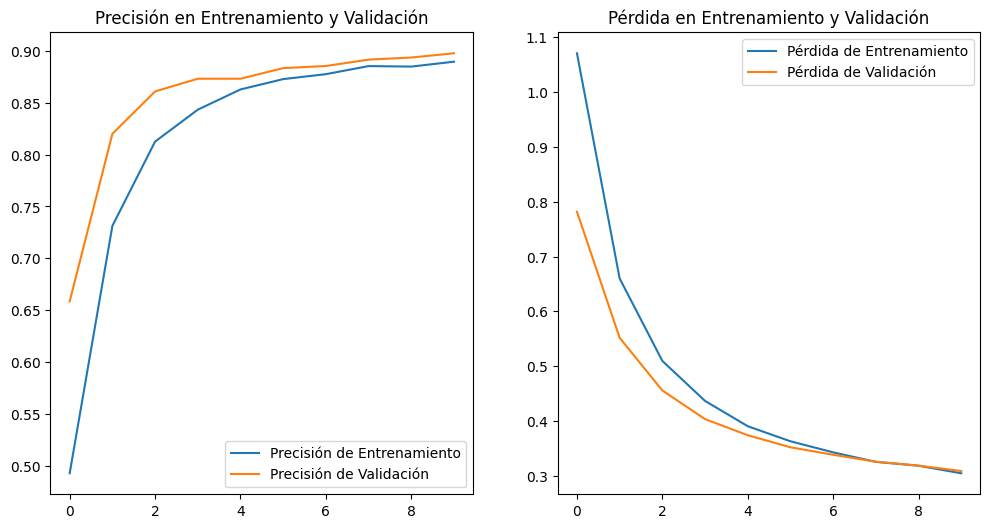

In [ ]:
# Graficar histórico de mobileNet
plot_training_history(history_mobilenet)

In [ ]:
#Cantidad de capas
print("Cantidad de capas ", len(base_model_mobilenet.layers))

fine_tune_at = (int) (len(base_model_mobilenet.layers)* 1/3)
print("Descongelar 1/3 de las capas desde el final, se descongelaran: ", fine_tune_at, " capas")

base_model_mobilenet.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_mobilenet.layers[:fine_tune_at]:
  layer.trainable = False

Cantidad de capas  154
Descongelar 1/3 de las capas desde el final, se descongelaran:  102  capas


In [ ]:
model_mobilenet.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

epocas_final = len(history_mobilenet.epoch) + EPOCAS_AFINACION

history_mobilenet_afinado = model_mobilenet.fit(train_dataset_mobilenet,
                                                initial_epoch= len(history_mobilenet.epoch),
                                                validation_data= val_dataset_mobilenet,
                                                epochs= epocas_final)

Epoch 11/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 64s 102ms/step - accuracy: 0.8265 - loss: 0.4150 - val_accuracy: 0.8773 - val_loss: 0.3193
Epoch 12/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 35s 76ms/step - accuracy: 0.9107 - loss: 0.2364 - val_accuracy: 0.8957 - val_loss: 0.2880
Epoch 13/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.9261 - loss: 0.1910 - val_accuracy: 0.9080 - val_loss: 0.2572
Epoch 14/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.9437 - loss: 0.1560 - val_accuracy: 0.9182 - val_loss: 0.2326
Epoch 15/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.9512 - loss: 0.1349 - val_accuracy: 0.9223 - val_loss: 0.2131
Epoch 16/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - accuracy: 0.9566 - loss: 0.1229 - val_accuracy: 0.9223 - val_loss: 0.2009
Epoch 17/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.9637 - loss: 0.1002 - val_accuracy: 0.9264 - val_loss: 0.1982
Epoch 18/20
458/458 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.9694 - loss: 

In [ ]:
# Compilar resultados de afinación
history_mobilenet.history['accuracy'] = history_mobilenet.history['accuracy'] + history_mobilenet_afinado.history['accuracy']
history_mobilenet.history['val_accuracy'] = history_mobilenet.history['val_accuracy'] + history_mobilenet_afinado.history['val_accuracy']
history_mobilenet.history['loss'] = history_mobilenet.history['loss'] + history_mobilenet_afinado.history['loss']
history_mobilenet.history['val_loss'] = history_mobilenet.history['val_loss'] + history_mobilenet_afinado.history['val_loss']

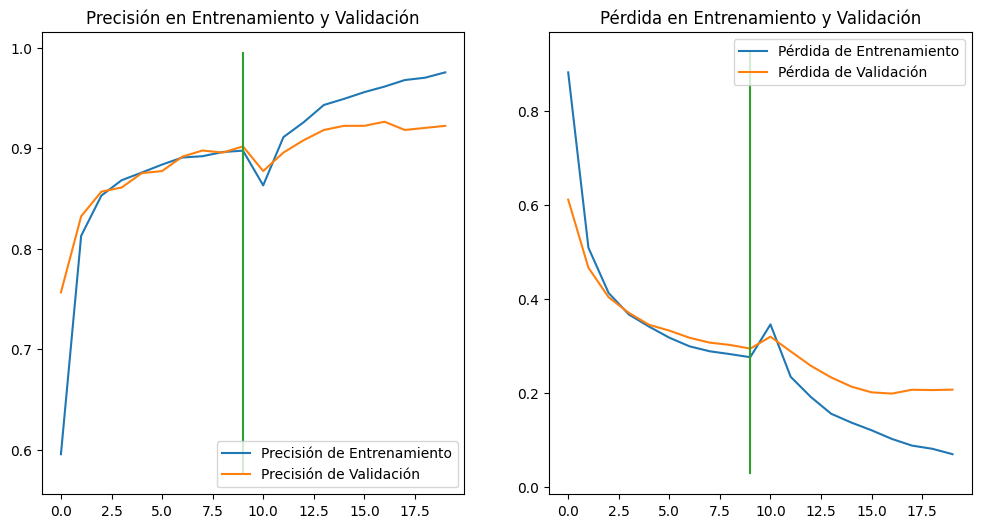

In [ ]:
# Graficar histórico despues del entrenamiento afinado
plot_training_history(history_mobilenet, True)

In [ ]:
# Evaluar el modelo
test_loss, val_acc_mobilenet = model_mobilenet.evaluate(val_dataset_mobilenet)
print(f"Accuracy: {val_acc_mobilenet}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 398ms/step - accuracy: 0.9030 - loss: 0.3044
Accuracy: 0.8977504968643188


In [ ]:
# Evaluar el modelo
test_loss, test_acc_mobilenet = model_mobilenet.evaluate(test_dataset_mobilenet)
print(f"Accuracy: {test_acc_mobilenet}")
# Obtener predicciones
y_pred_mobilenet = model_mobilenet.predict(test_dataset_mobilenet)
y_pred_mobilenet_classes = np.argmax(y_pred_mobilenet, axis=1)
y_true_mobilenet = np.concatenate([y.numpy() for x, y in test_dataset_mobilenet], axis=0)
y_true_mobilenet_classes = np.argmax(y_true_mobilenet, axis=1)

# Calcular F1-score, precisión y recall
f1 = f1_score(y_true_mobilenet_classes, y_pred_mobilenet_classes, average='weighted')
precision = precision_score(y_true_mobilenet_classes, y_pred_mobilenet_classes, average='weighted')
recall = recall_score(y_true_mobilenet_classes, y_pred_mobilenet_classes, average='weighted')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7818 - loss: 0.5249
Accuracy: 0.7852233648300171
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
F1 Score: 0.7836898164099901
Precision: 0.7883121079366211
Recall: 0.7852233676975945


In [ ]:
y_pred_mobilenet

array([[0.8946663 , 0.07872374, 0.02660994],
       [0.90930355, 0.01054144, 0.08015506],
       [0.5821831 , 0.02704506, 0.39077178],
       ...,
       [0.64168614, 0.00809812, 0.35021573],
       [0.3793382 , 0.04668042, 0.57398134],
       [0.18248439, 0.15507293, 0.6624426 ]], dtype=float32)

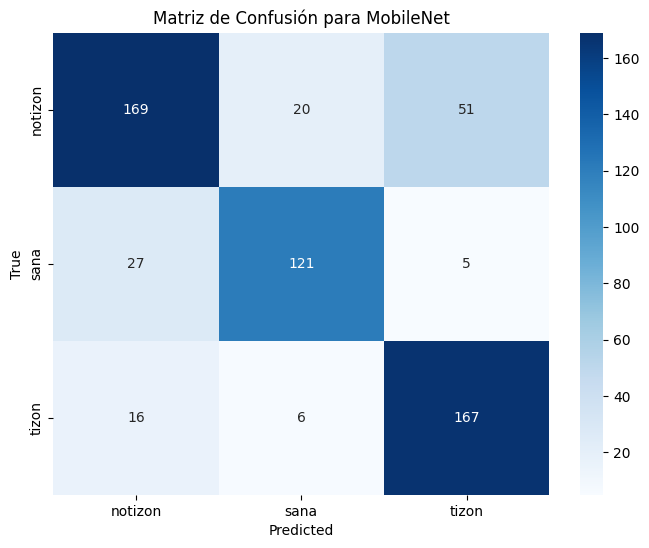

In [ ]:
# Calcular la matriz de confusión
class_names = train_dataset_mobilenet.class_names
cm = confusion_matrix(y_true_mobilenet_classes, y_pred_mobilenet_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión para MobileNet')
plt.show()

In [ ]:
model_mobilenet.save('modelo_mobilenet.keras')

In [ ]:
from tensorflow import keras

# Cargar el modelo que has entrenado y guardado previamente
modelCel = keras.models.load_model('modelo_mobilenet.keras')

In [ ]:
# Crear el convertidor de TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(modelCel)

# Convertir el modelo
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpvb5g4ad6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136269040766816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136269040775792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136269040774912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136269040770160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136269040772624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136269041239664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136269041240192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136269041244416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136269041239840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136269041238608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1362690412461

In [ ]:
# Guardar el modelo convertido en un archivo .tflite
with open('modelo_mobilenet.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Ruta de tu modelo .tflite
tflite_model_path = '/content/modelo_mobilenet.tflite'

# Carga el modelo TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

In [ ]:
# Obtiene detalles de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Imprime información sobre la entrada
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print("Forma de entrada:", input_shape)
print("Forma de salida:", output_shape)

Forma de entrada: [  1 224 224   3]
Forma de salida: [1 3]


In [ ]:
from PIL import Image

In [ ]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))  # Ajusta el tamaño a lo esperado por MobileNetV2
    img_array = np.array(img, dtype=np.float32)
    #img_array = preprocess_input(img_array)  # Usa el mismo preprocesamiento
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
# Ruta de la imagen de prueba
test_image_path = '/content/nt1.JPG'

# Preprocesa la imagen
input_data = preprocess_image(test_image_path)

# Configura el tensor de entrada
interpreter.set_tensor(input_details[0]['index'], input_data)

# Ejecuta la inferencia
interpreter.invoke()

# Obtiene la salida
output_data = interpreter.get_tensor(output_details[0]['index'])

# Imprime los resultados
print("Resultados de inferencia:", output_data)
# Si es una clasificación, podrías obtener la clase de mayor confianza
predicted_class = np.argmax(output_data)
print("Clase predicha:", predicted_class)

Resultados de inferencia: [[0.3774003  0.5381916  0.08440804]]
Clase predicha: 1


In [ ]:
# Directorio de entrenamiento utilizado para entrenar el modelo
train_dir = '/content/dataset/Dataset/train'
labels = sorted(os.listdir(train_dir))

# Usando los resultados de inferencia anteriores
predicted_class = np.argmax(output_data)
predicted_label = labels[predicted_class]

print("Índice de la clase predicha:", predicted_class)
print("Etiqueta de la clase predicha:", predicted_label)

Índice de la clase predicha: 1
Etiqueta de la clase predicha: sana


In [ ]:
# Directorio de imágenes y etiquetas de clases
test_dir = DATASET_DIR_VALID
class_names = sorted(os.listdir(test_dir))  # Asume que los nombres de carpeta son las clases en orden alfabético

# Contadores de evaluación
total_images = 0
correct_predictions = 0

# Evaluación por cada clase
for class_index, class_name in enumerate(class_names):
    class_path = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        input_data = preprocess_image(image_path)

        # Ejecuta la inferencia
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_class = np.argmax(output_data)

        # Verifica si la predicción es correcta
        if predicted_class == class_index:
            correct_predictions += 1
        total_images += 1

# Calcula el porcentaje de aciertos
accuracy = correct_predictions / total_images * 100
print(f"Precisión en el conjunto de prueba: {accuracy:.2f}%")

Precisión en el conjunto de prueba: 25.15%


In [ ]:
test_image_path = '/content/s1.JPG'

In [ ]:
# Inferencia con el modelo Keras
keras_predictions = model_mobilenet.__call__(preprocess_image(test_image_path))

# Inferencia con el modelo TFLite
interpreter.set_tensor(input_details[0]['index'], preprocess_image(test_image_path))
interpreter.invoke()
tflite_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Predicción Keras:", keras_predictions)
print("Predicción TFLite:", tflite_predictions)

Predicción Keras: tf.Tensor([[0.13886005 0.7325633  0.12857668]], shape=(1, 3), dtype=float32)
Predicción TFLite: [[0.13885878 0.7325654  0.12857577]]
